In [389]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [390]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [391]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [392]:
#Construction de la matrice de raideur relative à un élement triangulaire
def raideur_triangle(sommets):
    a1,a2,a3=sommets
    # Calcul de la matrice J
    J = np.array([[a2[0]-a1[0], a3[0]-a1[0]],[a2[1]-a1[1], a3[1]-a1[1]]])
    alpha = np.linalg.det(J)
    
    m = np.zeros((3,3))
    # Calcul des coefficients de M 
    for i in range(3):
        for j in range(3):
            # Calcul des dérivées des fonctions de base sur le triangle 
            dni = (1/alpha) * np.array([[sommets[(i+1)%3][1]-sommets[(i+2)%3][1]], [sommets[(i+2)%3][0]-sommets[(i+1)%3][0]]])
            dnj = (1/alpha) * np.array([[sommets[(j+1)%3][1]-sommets[(j+2)%3][1]], [sommets[(j+2)%3][0]-sommets[(j+1)%3][0]]])
            # Calcul du coefficient (i,j)
            m[i][j] = (alpha/2) * (np.transpose(dni).dot(dnj))
    
    return m, alpha

In [393]:
#Assemblage de la matrice dans le cas d'un maillage uniquement constitué de triangles
def assemblage_triangle(elements3, coordinates, dirichlet):
    l = len(coordinates)
    a = np.zeros((l,l))
    b = np.zeros((l,1))
    
    def f(x,y):
        return 1

    # Calcul de la matrice de raideur globale
    for i in range(len(elements3)):
        # Récupération des sommets de l'élément
        sommets = [coordinates[elements3[i][0]], coordinates[elements3[i][1]], coordinates[elements3[i][2]]]
        # Calcul de la matrice de raideur de l'élément
        m, alpha = raideur_triangle(sommets)
        # Assemblage de la matrice de raideur globale
        # Calcul du centre de gravité de l'élément
        cg = (1/3) * (sommets[0] + sommets[1] + sommets[2])
        for j in range(3):
            for k in range(3):
                a[elements3[i][j]][elements3[i][k]] += m[j][k]
            #Approximation pour la quadrature du second membre

            b[elements3[i][j]] += (alpha/6) * f(cg[0],cg[1])

    #Condition de Dirichlet
    def ud(x,y):
        return 1
    
    ld, cd = np.shape(dirichlet)
    v = np.zeros((l,1))

    for i in range(ld):
        idsommet = dirichlet[i,0]
        x,y = coordinates[idsommet]
        v[idsommet] = ud(x,y)
    
    # modification de b par rapport à la condition de Dirichlet 
    b = b - a.dot(v)
    uh = v
    
    # calcul des éléments a l'intérieur du domaine
    sommets = [i for i in range(l)]
    sommets_int = np.setdiff1d(sommets, dirichlet)
    al = a[sommets_int]
    amod = al[:,sommets_int]
    bmod = b[sommets_int]
    # on calcul u sur les points intérieurs, avec les matrices 
    # A et b modifiées qui n'ont que les éléments qui 
    # permettent de calculer la solution sur l'intérieur du domaine 
    umod =  (np.linalg.inv(amod)).dot(bmod)
    uh[sommets_int] = umod 
    
    return uh, amod, bmod
    

    

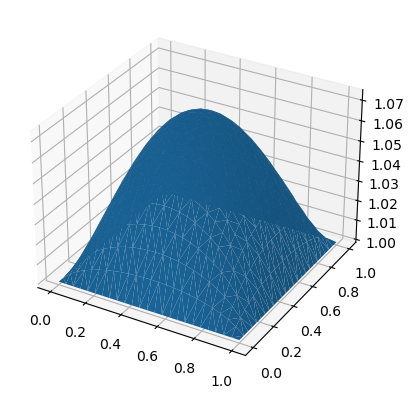

In [394]:
coordinates, elements3, dirichlet, neumann = maillage(25)
uh,a,b = assemblage_triangle(elements3, coordinates, dirichlet)
show(coordinates, (uh[:,0]))

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [395]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [396]:
#Construction de la matrice de raideur ́eĺémentaire relative à un élément quadrangle
def raideur_quadrangle(sommets):
    a1,a2,a3,a4=sommets
    # Calcul de la matrice J
    J = np.array([[a2[0]-a1[0], a3[0]-a1[0]],[a2[1]-a1[1], a3[1]-a1[1]]])
    alpha = np.linalg.det(J)
    
    m = np.zeros((4,4))
    # Calcul des coefficients de M 
    for i in range(4):
        for j in range(4):
            # Calcul des dérivées des fonctions de base sur le quadrangle 
            dni = (1/alpha) * np.array([[sommets[(i+1)%4][1]-sommets[(i+3)%4][1]], [sommets[(i+3)%4][0]-sommets[(i+1)%4][0]]])
            dnj = (1/alpha) * np.array([[sommets[(j+1)%4][1]-sommets[(j+3)%4][1]], [sommets[(j+3)%4][0]-sommets[(j+1)%4][0]]])
            # Calcul du coefficient (i,j)
            m[i][j] = (alpha/4) * (np.transpose(dni).dot(dnj))
    
    return m, alpha

In [397]:
#Assemblage de la matrice dans le cas d'un maillage uniquement constitué de rectangles
def assemblage_quadrangle(elements3, elements4, coordinates, dirichlet, neumann):
    l = len(coordinates)
    a = np.zeros((l,l))
    b = np.zeros((l,1))
    
    def f(x,y):
        return 1

    # Calcul de la matrice de raideur globale
    for i in range(len(elements3)):
        # Récupération des sommets de l'élément
        sommets = [coordinates[elements3[i][0]], coordinates[elements3[i][1]], coordinates[elements3[i][2]]]
        # Calcul de la matrice de raideur de l'élément
        m, alpha = raideur_triangle(sommets)
        # Assemblage de la matrice de raideur globale
        # Calcul du centre de gravité de l'élément
        cg = (1/3) * (sommets[0] + sommets[1] + sommets[2])
        for j in range(3):
            for k in range(3):
                a[elements3[i][j]][elements3[i][k]] += m[j][k]
            #Approximation pour la quadrature du second membre
            b[elements3[i][j]] += (alpha/6) * f(cg[0],cg[1])
    
    for i in range(len(elements4)):
        # Récupération des sommets de l'élément
        sommets = [coordinates[elements4[i][0]], coordinates[elements4[i][1]], coordinates[elements4[i][2]], coordinates[elements4[i][3]]]
        # Calcul de la matrice de raideur de l'élément
        m, alpha = raideur_quadrangle(sommets)
        # Assemblage de la matrice de raideur globale
        # Calcul du centre de gravité de l'élément
        cg = (1/4) * (sommets[0] + sommets[1] + sommets[2] + sommets[3])
        for j in range(4):
            for k in range(4):
                a[elements4[i][j]][elements4[i][k]] += m[j][k]
            #Approximation pour la quadrature du second membre
            b[elements4[i][j]] += (alpha/4) * f(cg[0],cg[1])

    # conditions de Dirichlet
    def ud(x,y):
        return 1
    
    v = np.zeros((l,1))
    for idsommet in dirichlet:
        x,y = coordinates[idsommet]
        v[idsommet] = ud(x,y)
    
    # modification de b par rapport à la condition de Dirichlet 
    b = b - a.dot(v)
    uh = v
    
    # conditions de Neumann 
    def g(x,y):
        return 1
    
    for i1,i2 in neumann:
        xa1,xa2, ya1,ya2 = coordinates[i1,0],coordinates[i2,0],coordinates[i1,1],coordinates[i2,1]
        # centre du segment
        x,y = (xa1 + xa2)/2, (ya1 + ya2)/2
        # distance entre les points
        d = math.sqrt((xa1 - xa2)**2 + (ya1 - ya2)**2)
        # approximation de la valeur ajoutée par les conditions de Neumann 
        # sur les sommets i1 et i2 
        ad = g(x,y)*(d/2)
        b[i1],b[i2] = b[i1] + ad, b[i2] + ad
    
    #calcul des éléments a l'intérieur du domaine
    sommets = [i for i in range(l)]
    sommets_int = np.setdiff1d(sommets, dirichlet)
    al = a[sommets_int]
    amod = al[:,sommets_int]
    bmod = b[sommets_int]
    # on calcul u sur les points intérieurs, avec les matrices 
    # A et b modifiées qui n'ont que les éléments qui 
    # permettent de calculer la solution sur l'intérieur du domaine 
    umod =  (np.linalg.inv(amod)).dot(bmod)
    uh[sommets_int] = umod
    
    return uh, amod, bmod


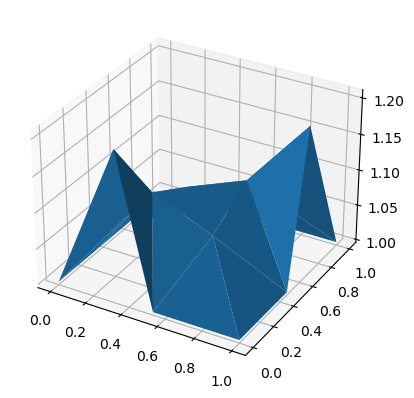

In [398]:
uh,ah,bh=assemblage_quadrangle(e3, e4, ccs, dds, nns)
show(ccs, (uh[:,0]))

**Compléments  :  un nouveau terme dans l'EDP**